# NLP

### Bucket checks

In [7]:
!aws s3 ls


2023-08-29 23:43:16 sagemaker-studio-692960231031-wo7kgoszj2g
2023-08-29 23:50:01 sagemaker-us-east-1-692960231031
2023-08-30 00:34:21 vad49
2023-09-16 16:02:10 vad49-labdata


In [44]:
!aws s3 ls s3://project17-bucket-alex/books/


2023-11-17 22:45:03     717850 pg1727.txt
2023-11-17 22:45:03    1201729 pg2554.txt
2023-11-17 22:45:03     513776 pg33.txt
2023-11-17 22:45:03     142082 pg5200.txt
2023-11-17 22:45:03     306317 pg64317.txt


In [43]:
# save books into bucket
if True is False:
    !aws s3 cp ../../data/external-data/books/ s3://project17-bucket-alex/books --recursive --exclude "*" --exclude ".ipynb_checkpoints/*" --include "*.txt"


upload: ../../data/external-data/books/pg1727.txt to s3://project17-bucket-alex/books/pg1727.txt
upload: ../../data/external-data/books/pg33.txt to s3://project17-bucket-alex/books/pg33.txt
upload: ../../data/external-data/books/.ipynb_checkpoints/pg64317-checkpoint.txt to s3://project17-bucket-alex/books/.ipynb_checkpoints/pg64317-checkpoint.txt
upload: ../../data/external-data/books/pg2554.txt to s3://project17-bucket-alex/books/pg2554.txt
upload: ../../data/external-data/books/pg5200.txt to s3://project17-bucket-alex/books/pg5200.txt
upload: ../../data/external-data/books/.ipynb_checkpoints/pg2554-checkpoint.txt to s3://project17-bucket-alex/books/.ipynb_checkpoints/pg2554-checkpoint.txt
upload: ../../data/external-data/books/.ipynb_checkpoints/pg1727-checkpoint.txt to s3://project17-bucket-alex/books/.ipynb_checkpoints/pg1727-checkpoint.txt
upload: ../../data/external-data/books/.ipynb_checkpoints/pg33-checkpoint.txt to s3://project17-bucket-alex/books/.ipynb_checkpoints/pg33-check

### Setup

In [9]:
#%%configure -f \
#{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

In [10]:
if True is True: # set to true only for the first un
    # Setup - Run only once per Kernel App
    %conda install openjdk -y

    # install PySpark
    %pip install pyspark==3.2.0 s3fs pyarrow spark-nlp

    # restart kernel
    from IPython.core.display import HTML
    HTML("<script>Jupyter.notebook.kernel.restart()</script>")


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, isnan, when, count, regexp_extract, weekofyear, hour, avg, to_date, unix_timestamp, lit, corr


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 150) 
#pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


In [12]:
# Import pyspark and build Spark session

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .config("spark-jars-packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
)

print(spark.version)

3.2.0


In [13]:
#from sparknlp.base import DocumentAssembler
#from sparknlp.annotator import LowerCase, Tokenizer
#import sparknlp


from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp

### Bring in submissions and comments data

In [14]:
%%time


required_columns = ['subreddit', 'title', 'selftext', 'score', 'created_utc', 'url']


# read the full year

# Read in data from project bucket
bucket = "project17-bucket-alex"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
submissions = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path).select(*required_columns)
    
    if submissions is None:
        submissions = month_df
    else:
        submissions = submissions.union(month_df)

        


23/11/17 22:11:18 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/17 22:11:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 59.1 ms, sys: 8.47 ms, total: 67.5 ms
Wall time: 16.4 s


In [15]:
submissions_small = submissions.sample(withReplacement=False, fraction=0.001, seed=42)



In [16]:
# create small dfs

use_small = True  # to easily swap between the small and small dfs
submissions_active = submissions_small if use_small else submissions



In [17]:
#cache - only for when working with the small version
#submissions_active.cache()


DataFrame[subreddit: string, title: string, selftext: string, score: bigint, created_utc: timestamp, url: string]

### Process Submissions Data


In [18]:
submissions_active.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- score: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- url: string (nullable = true)



### 2.2 Conduct basic data quality checks! Make sure there are no missing values, check the length of the comments, and remove rows of data that might be corrupted. Even if you think all your data is perfect, you still need to demonstrate that with your analysis.



Let's remove submissions without a body should obviously go, but what about the submissions without a self text (deleted, removed or empty). We can keep where the author is empty.

In [19]:

def clean_submissions(df: DataFrame) -> DataFrame:
    
    # define conditions
    conditions = (col('selftext') != "[removed]") & (col('selftext') != "[deleted]") & (col('selftext').isNotNull() & (col('selftext') != ""))

    
    # apply filter
    cleaned_df = df.filter(conditions)
  

    return cleaned_df




In [20]:
submissions_active = clean_submissions(submissions_active)


In [21]:
#display(f"submissions shape: ({submissions_active.count()}, {len(submissions_active.columns)})")

display(submissions_active.limit(5).toPandas())

,subreddit,title,selftext,score,created_utc,url
0,relationship_advice,I need advice,So my gf and I are both 19 and live separately but both in college and she works. We will live together within 2ish years after she graduates but ...,1,2022-01-25 17:01:32,https://www.reddit.com/r/relationship_advice/comments/scid7f/i_need_advice/
1,relationship_advice,Too smart to be this stupid; logics vs heart.,"My estranged bf of the last almost 2yrs has vowed to make his life mission, along others aid, to make me have misery and regret. \n Call me cr...",1,2022-01-18 17:12:58,https://www.reddit.com/r/relationship_advice/comments/s72fh8/too_smart_to_be_this_stupid_logics_vs_heart/
2,antiwork,High hopes for the future,"Just kidding, this sub is doomed\n\nHey mods, stop doing interviews \n\nYou don’t speak for the people of this sub. You are a janitor who’s only p...",0,2022-01-27 19:05:44,https://www.reddit.com/r/antiwork/comments/se5xf0/high_hopes_for_the_future/
3,NoStupidQuestions,I think I just ejaculated without trying,Okay so has anyone else have this happen. Right altering peeing. I get extreme pain I mean like eye shutting crouching over pain and there this cl...,1,2022-01-05 19:26:45,https://www.reddit.com/r/NoStupidQuestions/comments/rwuuej/i_think_i_just_ejaculated_without_trying/
4,socialskills,"Is it weird to tell my depressed friend I'm ""proud of him"" after he's overcome a bad mental phase?","One of my best friends suffers from depression and experiences ""down phases"" in irregular intervals. He always has a particularly bad one in winte...",131,2022-01-13 18:13:09,https://www.reddit.com/r/socialskills/comments/s35q0j/is_it_weird_to_tell_my_depressed_friend_im_proud/


In [22]:
# use regex the remove text after 'Edit: ' or 'edit: '

# The regular expression pattern
pattern = r"(?i)^(.*?)(?=Edit:|$)"

# Apply the regular expression to create a new column with the modified text
submissions_active = submissions_active.withColumn("selftext_modified", regexp_extract(col("selftext"), pattern, 1))



In [23]:
# define stories as posts longer than a certain length 

story_length = 4500

submissions_active = submissions_active.filter(length(col("selftext")) > story_length)


In [24]:
# keep only the 25% most engaging posts


# Calculate the approximate percentile of the 'score' column
quantile_value = submissions_active.approxQuantile("score", [0.85], 0.05)  # 0.05 is the relative error

# Filter the DataFrame to keep scores above or equal to this value
submissions_active = submissions_active.filter(col("score") >= quantile_value[0])



In [25]:
#display(f"submissions shape: ({submissions_active.count()}, {len(submissions_active.columns)})")


display(submissions_active.limit(5).toPandas())

,subreddit,title,selftext,score,created_utc,url,selftext_modified
0,relationship_advice,Is dating online cheating.. the whole story,Due to the overwhelming messages and requests for the whole story on about my last post. I decided to do a tell-all. So I hope you have a minute. ...,29,2022-07-13 15:48:56,https://www.reddit.com/r/relationship_advice/comments/vy6fh0/is_dating_online_cheating_the_whole_story/,
1,AmItheAsshole,AITA for expecting my son to share his room?,"Background: My (40sf) husband (40sm) and I bought a 3-bedroom house a few years ago, shortly before the panini. We of course took the master bedro...",16459,2022-10-26 08:51:01,https://www.reddit.com/r/AmItheAsshole/comments/ydt2w5/aita_for_expecting_my_son_to_share_his_room/,
2,AmItheAsshole,"WIBTA for taking my (15f) laundry basket full of clothes, which my stepdad (49m) threw out for not putting them away, out of the trash?",Sorry for bad English!\n\nThe morning before my clothes were thrown away my mom put them in a laundry basket beside my door. She did tell me ofcou...,95,2022-11-07 19:59:01,https://www.reddit.com/r/AmItheAsshole/comments/yoyf1r/wibta_for_taking_my_15f_laundry_basket_full_of/,
3,relationship_advice,My housemate (25f) did something I (20f) consider morally unacceptable and its causing a lot of conflict in the house (6 students).,Tl;dr version: I live in a student houseshare. One of my housemates is a student nurse and was extremely inappropriate with a patient which I foun...,421,2022-11-04 20:32:06,https://www.reddit.com/r/relationship_advice/comments/ym9kw7/my_housemate_25f_did_something_i_20f_consider/,
4,socialskills,How to Talk About Yourself (and How to Have Good Conversation),"**TL:DR talk about yourself by saying just a little bit in a way that's relevant to the topic at hand, and give the other person the implicit choi...",27,2022-12-01 14:46:48,https://www.reddit.com/r/socialskills/comments/z9polj/how_to_talk_about_yourself_and_how_to_have_good/,


Books

In [26]:
#import os

#def process_gutenberg_books(directory_path):
#    all_text = []
#    for filename in os.listdir(directory_path):
#        if filename.endswith('.txt'):  # Assuming the files are in .txt format
#            file_path = os.path.join(directory_path, filename)
#            with open(file_path, 'r', encoding='utf-8') as file:
#                content = file.read()
#                start_idx = content.find("*** START OF THE PROJECT GUTENBERG")
#                if start_idx != -1:
#                    # Find the end of the line and start from the next line
#                    start_idx = content.find('\n', start_idx) + 1
#                    content = content[start_idx:]
#                all_text.append(content)
#    return ' '.join(all_text)


#gutenberg_text = process_gutenberg_books('../../data/external-data/books')

#display(len(gutenberg_text))
#gutenberg_text[:500]

In [27]:
#submissions_text = submissions_active.select("selftext").rdd.flatMap(lambda x: x).collect()
#submissions_text = ' '.join(submissions_text)

#display(len(submissions_text))
#submissions_text[:500]

In [28]:
#combined_text = gutenberg_text + " " + submissions_text

#display(len(combined_text))
#display(combined_text[:500])

In [29]:
# Read the Gutenberg books into a Spark DataFrame
gutenberg_df = spark.read.text("../../data/external-data/books/*.txt")
gutenberg_df = gutenberg_df.withColumnRenamed("value", "text")



In [30]:
from pyspark.sql.functions import concat_ws, col

# Process `submissions_active` to extract and transform the 'selftext' column
submissions_df = submissions_active.select("selftext")





In [31]:
# For the Project Gutenberg DataFrame
gutenberg_df = gutenberg_df.withColumnRenamed("value", "text")

# For the submissions DataFrame
submissions_df = submissions_df.withColumnRenamed("selftext", "text")

# Now you can union them
combined_df = gutenberg_df.unionByName(submissions_df)

In [45]:
%%time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-nlp-project",
    framework_version="3.3",
    role=role,
    instance_count=2,  # Adjust as needed
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=7200,
)

session = sagemaker.Session()

# Define your S3 paths and other parameters
s3_dataset_path_submissions_bucket = "project17-bucket-alex"
s3_dataset_path_gutenberg = "s3://project17-bucket-alex/books/*.txt"
output_bucket = "project17-bucket-alex/stories-and-books-nlp/"

# Run the PySpark job
spark_processor.run(
    submit_app="project-nlp-posts-and-books-processing.py",
    arguments=[
        "--s3_dataset_path_submissions_bucket", s3_dataset_path_submissions_bucket,
        "--s3_dataset_path_gutenberg", s3_dataset_path_gutenberg,
        "--s3_output_bucket", output_bucket,
    ],
    spark_event_logs_s3_uri=f"s3://{output_bucket}/spark_event_logs",
    logs=True,
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


NameError: name 's3_dataset_path_commments' is not defined

In [35]:
import boto3

sagemaker = boto3.client('sagemaker')

response = sagemaker.create_processing_job(
    ProcessingJobName='spark-nlp-job',
    ProcessingResources={
        'ClusterConfig': {
            'InstanceCount': 2,
            'InstanceType': 'ml.m5.xlarge',
            'VolumeSizeInGB': 30
        }
    },
    AppSpecification={
        'ImageUri': 'your-spark-image-uri',
        'ScriptUri': 'spark_nlp_processing.py'
    },
    # Additional parameters like input/output configuration, roles, etc.
)

print(response)


ParamValidationError: Parameter validation failed:
Missing required parameter in input: "RoleArn"
Unknown parameter in AppSpecification: "ScriptUri", must be one of: ImageUri, ContainerEntrypoint, ContainerArguments

Final shape

In [29]:
%%time


# check counts

subreddit_counts = submissions_active.groupby('subreddit').count()
#subreddit_counts.show()

# store
subreddit_counts_df = subreddit_counts.toPandas()
subreddit_counts_df['subreddit'] = subreddit_counts_df['subreddit'].astype('category')
subreddit_counts_df.to_csv('../../data/eda-data/subreddit-counts.csv', index=False)

subreddit_counts_df


+-------------------+------+
|          subreddit| count|
+-------------------+------+
|     TrueOffMyChest|125159|
|   unpopularopinion| 39642|
|           antiwork| 76647|
|       socialskills| 23005|
|             AskMen| 18240|
|      AmItheAsshole|115659|
|relationship_advice|311882|
|  explainlikeimfive| 15002|
|       OutOfTheLoop|  3054|
|               tifu| 11921|
|  NoStupidQuestions|234253|
|           AskWomen|  2717|
+-------------------+------+



CPU times: user 597 ms, sys: 73.5 ms, total: 670 ms
Wall time: 10min 15s


### 2.5 Use data transformations to make AT LEAST 3 new variables that are relevant to your business questions. We cannot be more specific because this depends on your project and what you want to explore!



In [30]:
%%time

# define weights
weight_comments = 0.5
weight_score = 0.5


# make the new column
submissions_active = submissions_active.withColumn(
    'interaction_score',
    (col('num_comments') * weight_comments) + (col('score') * weight_score)
)



CPU times: user 3.05 ms, sys: 0 ns, total: 3.05 ms
Wall time: 86.6 ms


In [31]:
# check
submissions_active.printSchema()

root
 |-- created_utc: timestamp (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: integer (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- title: string (nullable = true)
 |-- interaction_score: double (nullable = true)



In [32]:
%%time

# make new cols
comments_active = comments_active.withColumn('week_of_year', F.weekofyear('created_utc'))
comments_active = comments_active.withColumn('hour_of_day', F.hour('created_utc'))

# check
comments_active.printSchema()

root
 |-- body: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)

CPU times: user 2.29 ms, sys: 342 µs, total: 2.63 ms
Wall time: 20 ms


### 2.3 Produce at least 5 interesting graphs about your dataset. Think about the dimensions that are interesting for your Reddit data! There are millions of choices. Make sure your graphs are connected to your business questions.



Topic 1

In [32]:
%%time

# uncomment if needed
#submissions_active.groupby('over_18').count().show()


+-------+------+
|over_18| count|
+-------+------+
|      1| 45151|
|      0|932030|
+-------+------+

CPU times: user 104 ms, sys: 30.1 ms, total: 134 ms
Wall time: 5min 27s


In [33]:
%%time

# get true cases for over_18
true_count = submissions_active.filter(col('over_18') == 1).count()

# sample the same number of false cases
false_count = submissions_active.filter(col('over_18') == 0).count()
fraction = true_count / false_count

sampled_false = submissions_active.filter(col('over_18') == 0).sample(withReplacement=False, fraction=fraction, seed=42)
sampled_false = sampled_false.limit(true_count)


# combine
combined = submissions_active.filter(col('over_18') == 1).unionAll(sampled_false)



CPU times: user 215 ms, sys: 45.8 ms, total: 261 ms
Wall time: 10min 32s


In [36]:
%%time

from pyspark.sql.functions import col, to_date, row_number
from pyspark.sql import Window
import pandas as pd

# Convert 'created_utc' to date format for grouping
submissions_active = submissions_active.withColumn('date', to_date('created_utc'))

# Sample up to 3 submissions per day where over_18 is true
true_sampled = submissions_active.filter(col('over_18') == 1)\
    .withColumn('row_num', row_number().over(Window.partitionBy('date').orderBy('date')))\
    .filter(col('row_num') <= 3)\
    .drop('row_num')

# Count the number of true samples per day
true_counts_per_day = true_sampled.groupBy('date').count().withColumnRenamed('count', 'true_count')

# Sample false submissions based on true counts per day
false_sampled = submissions_active.filter(col('over_18') == 0)\
    .join(true_counts_per_day, 'date', 'inner')\
    .withColumn('row_num', row_number().over(Window.partitionBy('date').orderBy('date')))\
    .filter(col('row_num') <= col('true_count'))\
    .select(true_sampled.columns)  # Ensure the schema matches with true_sampled

# Combine the samples
combined_samples = true_sampled.union(false_sampled)



CPU times: user 8.21 ms, sys: 8.24 ms, total: 16.4 ms
Wall time: 303 ms


In [37]:
%%time

# convert combined Spark DataFrame to pandas
#pandas_df = combined.toPandas()
pandas_df = combined_samples.toPandas()

# ensure 'over_18' is a string
pandas_df['over_18'] = pandas_df['over_18'].map({0: 'False', 1: 'True'})


# remove rows with more than 200 comments
#pandas_df = pandas_df[pandas_df['num_comments'] <= 200]


# save
pandas_df.to_csv('../../data/eda-data/box-plot-nsfw-data.csv', index=False)




CPU times: user 528 ms, sys: 111 ms, total: 639 ms
Wall time: 18min 1s


In [38]:
%%time

# check
counts = pandas_df['over_18'].value_counts()
print("Counts for 'over_18' in the DataFrame:")
print(counts)


Counts for 'over_18' in the DataFrame:
True     1095
False    1095
Name: over_18, dtype: int64
CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 1.99 ms


<Figure size 1000x600 with 0 Axes>

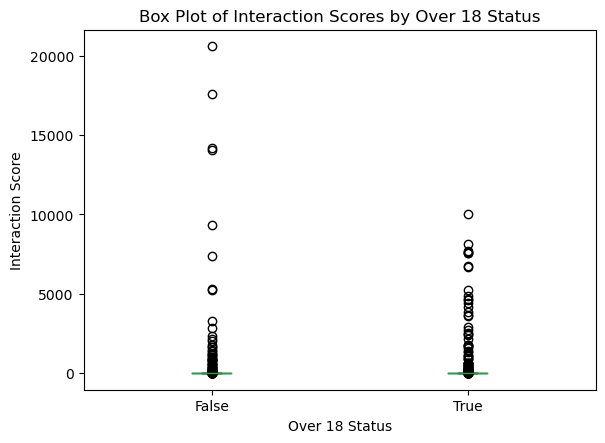

In [39]:
# simple plot for checking the data
plt.figure(figsize=(10, 6))
ax = pandas_df.boxplot(by='over_18', column=['interaction_score'], grid=False)

# format
ax.set_title('Box Plot of Interaction Scores by Over 18 Status')
ax.set_xlabel('Over 18 Status')
ax.set_ylabel('Interaction Score')
plt.suptitle('') 

# show
plt.show()

Topic 2

In [55]:
#submissions_active.show()

In [40]:
%%time


# group by 'subreddit' and calculate the mean of 'num_comments' and 'score'
subreddit_means = submissions_active.groupBy('subreddit') \
                                    .agg(F.mean('num_comments').alias('mean_num_comments'), 
                                         F.mean('score').alias('mean_score'))

# convert to pandas
pandas_df_means = subreddit_means.toPandas()

# ensure the 'subreddit' is treated as a category
pandas_df_means['subreddit'] = pandas_df_means['subreddit'].astype('category')

# save data
pandas_df_means.to_csv('../../data/eda-data/mean-comments-vs-mean-score-data.csv', index=False)




CPU times: user 114 ms, sys: 35.2 ms, total: 150 ms
Wall time: 6min 4s


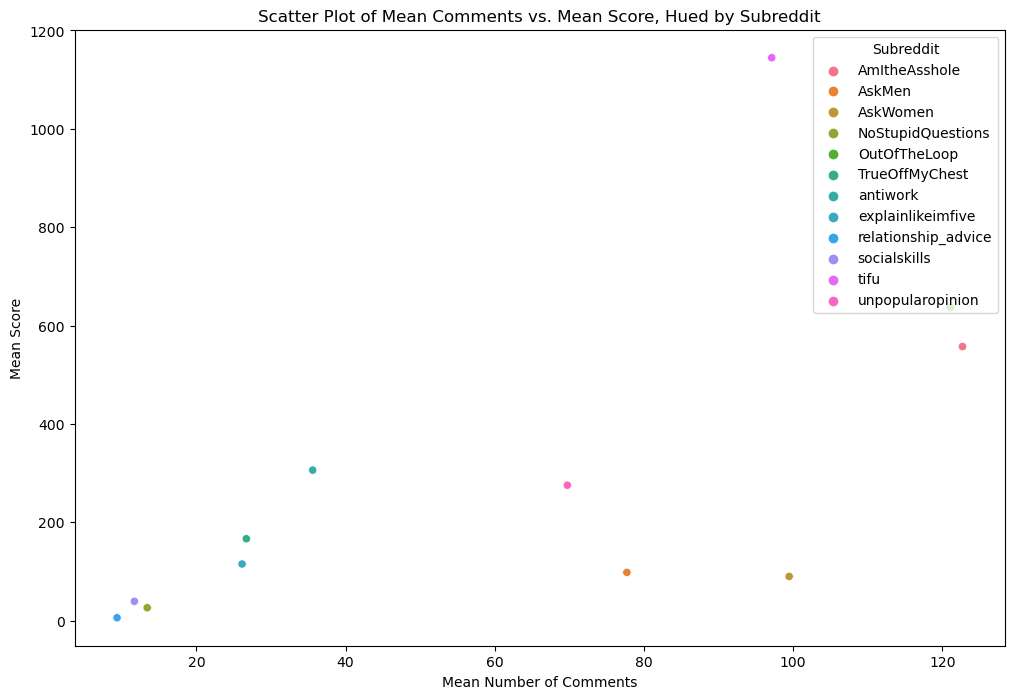

In [41]:

# basic plot for checking data
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(data=pandas_df_means, 
                               x='mean_num_comments', 
                               y='mean_score', 
                               hue='subreddit')

# format
scatter_plot.set_title('Scatter Plot of Mean Comments vs. Mean Score, Hued by Subreddit')
scatter_plot.set_xlabel('Mean Number of Comments')
scatter_plot.set_ylabel('Mean Score')
plt.legend(title='Subreddit', loc='upper right')


# show
plt.show()



Topic 3

In [42]:
%%time

# filter out before Jan 3rd, 2021 and it will be considered week 53 of 2020
comments_active = comments_active.filter(to_date(col('created_utc')) > lit('2022-01-02'))


# group and pivot
comments_grouped = comments_active.groupBy('week_of_year', 'hour_of_day').count()
comments_pivot = comments_grouped.groupBy('week_of_year').pivot('hour_of_day').avg('count').orderBy('week_of_year')

# convert to pandas
comments_pivot_df = comments_pivot.toPandas().set_index('week_of_year')


# save
comments_pivot_df.to_csv('../../data/eda-data/average-comments-hour-and-week-data.csv', index=True)



CPU times: user 823 ms, sys: 218 ms, total: 1.04 s
Wall time: 38min 24s


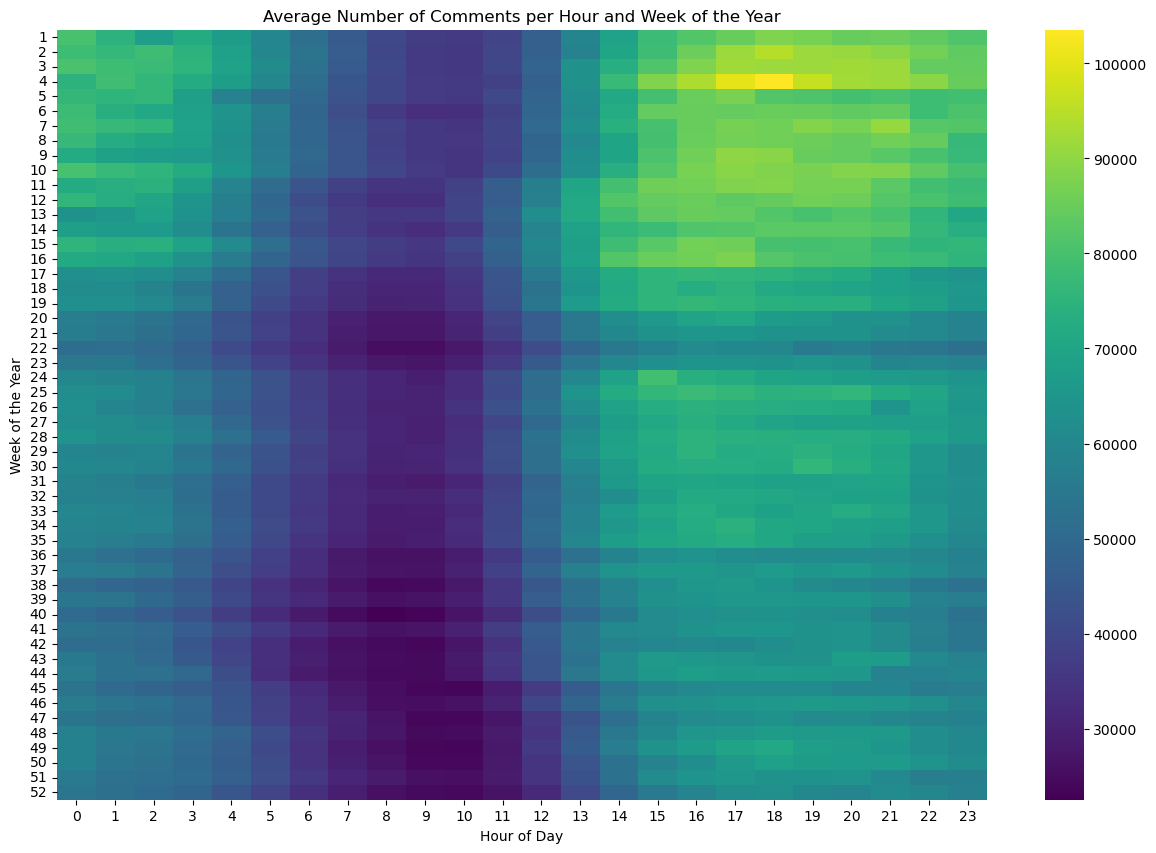

In [43]:
# basic plot for checking data
plt.figure(figsize=(15, 10))
sns.heatmap(comments_pivot_df, cmap='viridis')
plt.title('Average Number of Comments per Hour and Week of the Year')
plt.xlabel('Hour of Day')
plt.ylabel('Week of the Year')
plt.show()



### 2.4 Produce at least 3 interesting summary tables about your dataset. You can decide how to split up your data into categories, time slices, etc. There are infinite ways you can make summary statistics. Be unique, creative, and interesting!



In [44]:
%%time

# calculate correlations
correlation_by_subreddit = submissions_active.groupBy('subreddit') \
                                             .agg(corr(col('num_comments'), col('score')).alias('correlation_coefficient'))
correlation_by_subreddit.show()


# pd and save
pandas_df_correlation_table = correlation_by_subreddit.toPandas()
pandas_df_correlation_table.to_csv('../../data/eda-data/correlation_by_subreddit.csv', index=False)


+-------------------+-----------------------+
|          subreddit|correlation_coefficient|
+-------------------+-----------------------+
|     TrueOffMyChest|     0.7904492302904506|
|   unpopularopinion|     0.8329072730253577|
|           antiwork|     0.8203507005224446|
|       socialskills|     0.7242256969368244|
|             AskMen|     0.8502598438075363|
|      AmItheAsshole|      0.805089104203968|
|relationship_advice|     0.6443628370134271|
|  explainlikeimfive|     0.8761328465188262|
|       OutOfTheLoop|     0.8587867080726921|
|               tifu|     0.8152184885458167|
|  NoStupidQuestions|      0.782943169928124|
|           AskWomen|     0.7737802547562187|
+-------------------+-----------------------+



CPU times: user 236 ms, sys: 48.9 ms, total: 285 ms
Wall time: 11min 58s


### 2.6 Implement regex searches for specific keywords of interest to produce dummy variables and then make statistics that are related to your business questions. Note, that you DO NOT have to do textual cleaning of the data at this point. The next assignment on NLP will focus on the textual cleaning and analysis aspect.



In [ ]:
%%time

keywords = ['fascinating', 'entertaining', 'boring']
combined_counts = {}

# init dataframe not work on original
comments_active_dummies = comments_active


# create dummies
for keyword in keywords:
    comments_active_dummies = comments_active_dummies.withColumn(
        keyword, 
        (regexp_extract(col('body'), f'\\b{keyword}\\b', 0) != '').cast('integer')
    )

for keyword in keywords:
    count_df = comments_active_dummies.groupBy(keyword).count().toPandas()
    # Export each DataFrame to a CSV file
    count_df.to_csv(f'../../data/eda-data/keyword_counts_{keyword}.csv', index=False)

# loop through keyworkds, get count and collect
#for keyword in keywords:
#    count_df = comments_active_dummies.groupBy(keyword).count().toPandas()
#    count_df.set_index(keyword, inplace=True)  # Set the keyword column as the index
#    combined_counts[keyword] = count_df

    
# concat
#combined_df = pd.concat(combined_counts.values(), axis=1, keys=combined_counts.keys())

# check
#print(combined_df)


# save data

#combined_df.to_csv('../../data/eda-data/dummies_keywords_count.csv')



### 2.7 Find some type of external data to join onto your Reddit data. Don’t know what to pick? Consider a time-related dataset. Stock prices, game details over time, active users on a platform, sports scores, covid cases, etc., etc. While you may not need to join this external data with your entire dataset, you must have at least one analysis that connects to external data. You do not have to join the external data and analyze it yet, just find it.



### If you are planning to make any custom datasets that are derived from your Reddit data, make them now. These datasets might be graph-focused, or maybe they are time series focused, it is completely up to you!